In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
from collections import Counter
from datetime import timedelta, datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

from keras.layers import Dense, Dropout
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from xgboost import XGBClassifier

# 0. read data 

- `data/train.csv` - 10506 rows × 12 columns with `WnvPresent` and `NumMosquitos`
    1. Date: date that the WNV test is performed
    2. Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
    3. Species: the species of mosquitos
    4. Block: block number of address
    5. Street: street name
    6. Trap: Id of the trap
    7. AddressNumberAndStreet: approximate address returned from GeoCoder
    8. Latitude
    9. Longitude
    10. AddressAccuracy: accuracy returned from GeoCoder
    11. **NumMosquitos**: number of mosquitoes caught in this trap
    12. **WnvPresent**: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 
- `data/test.csv` - 116293 rows × 10 columns 
- `data/spray.csv` - 14835 rows × 4 columns
    - `Date`, `Time`, `Latitude`, `Longitude`
- `data/weather.csv` - 2944 rows × 22 columns
    - `Station`, `Date`, `Tmax`, `Tmin`, `Tavg`, `Depart`, `DewPoint`, `WetBulb`, `Heat`, `Cool`, `Sunrise`, `Sunset`, `CodeSum`, `Depth`, `Water1`, `SnowFall`, `PrecipTotal`, `StnPressure`, `SeaLevel`, `ResultSpeed`, `ResultDir`, `AvgSpeed`

In [46]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
spray = pd.read_csv('data/spray.csv')
weather = pd.read_csv('data/weather.csv')

In [47]:
def get_month(date, divide_3=False):
    year, month, day = date.year, date.month, date.day
    year_month = str(year) + '_' + str(month).zfill(2)
    if divide_3:
        if day < 10:
            return year_month + ' early'
        elif day < 20:
            return year_month + ' mid'
        else:
            return year_month + ' late'
    else:
        return year_month

## Create new columns : year, month, year_month
train['Date'] = pd.to_datetime(train.Date)
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Year_Month'] = train.Date.apply(get_month)  ## 2013, 8 -> 2013_08
train['Year_Month3'] = train.Date.apply(lambda x: get_month(x, divide_3=True))  ## month + (early, mid, late)

## mapped target label to string
train['WnvPresent_num'] = train['WnvPresent']  ## original column - 0 or 1
train['WnvPresent'] = train['WnvPresent'].map({0:'not present', 1:'present'})  ## mapped string

# 1. EDA

## 1.1. numerical features :

- `WnvPresent` (bool) - target variable
- `NumMosquitos` (int) - not exist in test data 
- `Year`
- `Month`
- `Latitude`
- `Longitude`
- `AddressAccuracy` (int)

#### all correlations

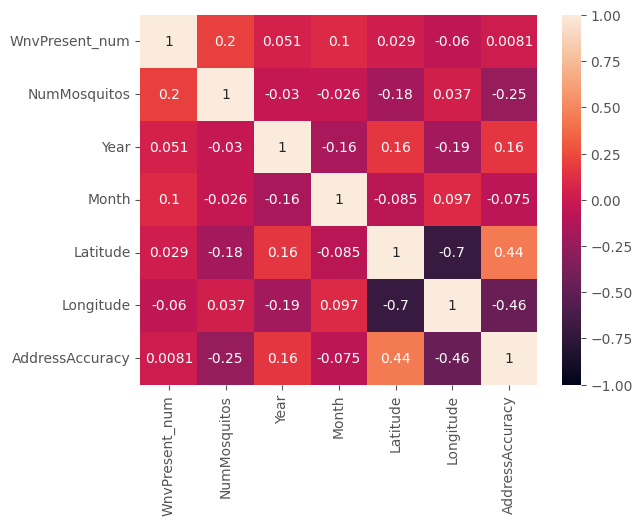

In [48]:
num_cols = ['WnvPresent_num','NumMosquitos','Year','Month','Latitude','Longitude','AddressAccuracy']
sns.heatmap(train[num_cols].corr(), annot=True, vmin=-1, vmax=1);

#### WNV by time

- most frequently observed every August

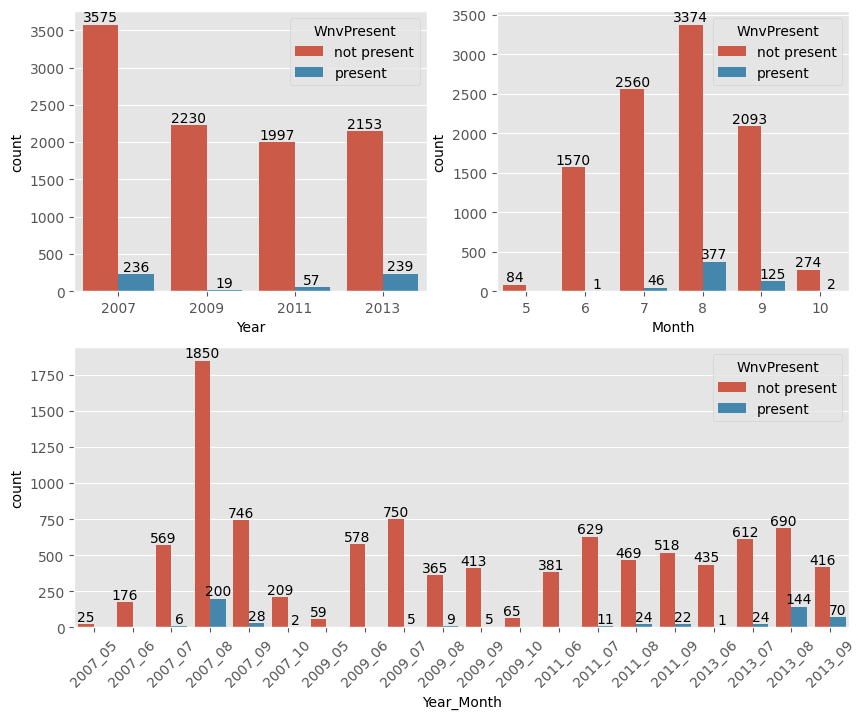

In [49]:
## visualization by datetime
fig, axes = plt.subplot_mosaic("AB;CC", figsize=(10, 8))

## WNV by year
ax = sns.countplot(x='Year', hue='WnvPresent', data=train, ax=axes['A'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

## WNV by month
ax = sns.countplot(x='Month', hue='WnvPresent', data=train, ax=axes['B'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

## WNV by year-month 
ax = sns.countplot(x='Year_Month', hue='WnvPresent', data=train, ax=axes['C'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=45);

### plot `Latitude` and `Longitude` to map

- WNV is widely observed in Chicago
- plot size is `NumMosquitos` 

In [62]:
## plot one month
fig = px.scatter_mapbox(
    data_frame=train[(train.Year_Month == "2013_08")],
    title="year = 2013_08",
    lat="Latitude", lon="Longitude",
    size="NumMosquitos",
    color='WnvPresent',
    zoom=9.5,
    height=800, width=800,
    mapbox_style='open-street-map')
fig.show()

In [61]:
## plot only Present by year_month
fig = px.scatter_mapbox(
    data_frame=train[train.WnvPresent_num==1],
    lat="Latitude", lon="Longitude",
    color='WnvPresent',
    size="NumMosquitos",
    animation_frame='Year_Month3',
    mapbox_style='carto-positron',           
    zoom=9.5,
    height=800, width=800)
fig.show();


## 1.2. categorical features

- `Species` - 7 unique values
- `Street` - 128 unique values
- `Address` -138 unique values
- `Trap` - 136 unique values 

#### `Species`

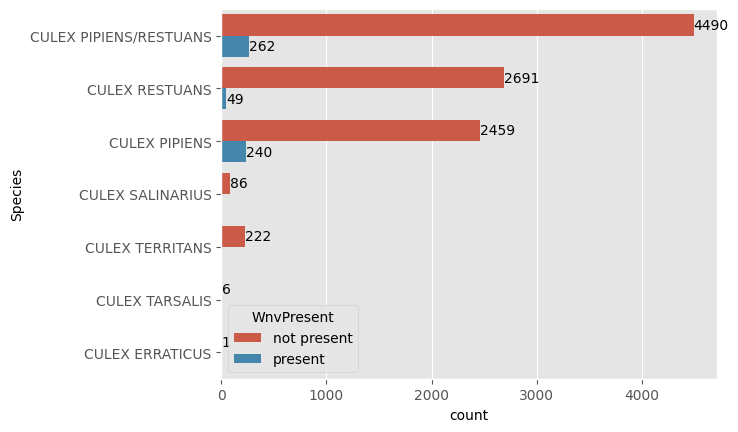

In [52]:
ax = sns.countplot(y='Species', hue='WnvPresent', data=train)
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1]);

#### `Trap`

In [59]:
train['Trap'].value_counts()

Trap
T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: count, Length: 136, dtype: int64

## 1.3. spray data

- 4 columns
    - `Date`
    - `Time`
    - `Latitude`
    - `Longitude`
- only 2011 (2 days) and 2013 (8 days)

In [54]:
## Create new columns : year, month, year_month
spray['Date'] = pd.to_datetime(spray.Date)
spray['Year'] = spray.Date.dt.year
spray['Month'] = spray.Date.dt.month
spray['Year_Month'] = spray.apply(lambda row: str(row['Year'])+'_'+str(row['Month']).zfill(2), axis=1)
spray

Date        Time   Latitude  Longitude  Year  Month Year_Month
0     2011-08-29  6:56:58 PM  42.391623 -88.089163  2011      8    2011_08
1     2011-08-29  6:57:08 PM  42.391348 -88.089163  2011      8    2011_08
2     2011-08-29  6:57:18 PM  42.391022 -88.089157  2011      8    2011_08
3     2011-08-29  6:57:28 PM  42.390637 -88.089158  2011      8    2011_08
4     2011-08-29  6:57:38 PM  42.390410 -88.088858  2011      8    2011_08
...          ...         ...        ...        ...   ...    ...        ...
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355  2013      9    2013_09
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015  2013      9    2013_09
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392  2013      9    2013_09
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423  2013      9    2013_09
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460  2013      9    2013_09

[14835 rows x 7 columns]

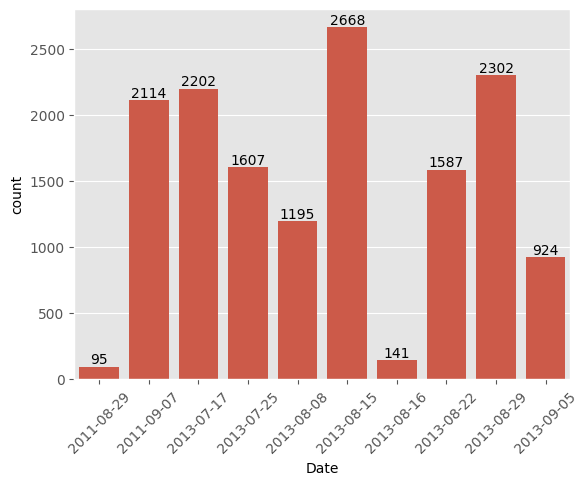

In [55]:
## spray times
ax = sns.countplot(data=spray, x='Date')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45);

In [72]:
fig = px.scatter_mapbox(
    data_frame=spray,
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    color='Date',
    height=800, width=800,
    mapbox_style='open-street-map')
fig.show()

#### Does spraying help reducing mosquitos?

- 2011-09-07
- 2013-07-17
- 2013-07-25
- 2013-08-08
- 2013-08-15
- 2013-08-16
- 2013-08-22
- 2013-08-29
- 2013-09-05

In [70]:
def present_after_spray(year, month, day, durations=[0, 7, 14, 21, 28]):
    spray_date = datetime(year, month, day)
    date_filter = (spray.Date==spray_date)

    ## get the location of corners of the sprayed block
    long_min = spray.loc[date_filter, 'Longitude'].min()
    long_max = spray.loc[date_filter, 'Longitude'].max()
    lat_min = spray.loc[date_filter, 'Latitude'].min()
    lat_max = spray.loc[date_filter, 'Latitude'].max()

    ## train data within duration
    result_df = pd.DataFrame(index=['not present', 'present'])
    for i in range(len(durations) - 1):
        duration_start, duration_end = durations[i], durations[i+1]
        date_condition = (train.Date > spray_date + timedelta(days=duration_start)) & (train.Date <= spray_date + timedelta(days=duration_end))
        long_condition = (train.Longitude >= long_min) & (train.Longitude <= long_max)
        lat_condition = (train.Latitude >= lat_min) & (train.Latitude <= lat_max)
        filtered = train[date_condition & long_condition & lat_condition]
        
        result_df[f'{duration_start}-{duration_end} days'] = len(filtered[filtered.WnvPresent_num==0]), len(filtered[filtered.WnvPresent_num==1])

    print(f'--- after spray @ {str(spray_date).split()[0]} ---')
    display(result_df); print()

In [71]:
spray_dates = [(2011,9,7), (2013,7,17), (2013,7,25), (2013,8,8), (2013,8,15), (2013,8,16), (2013,8,22), (2013,8,29), (2013,9,5)]
for y, m, d in spray_dates:
    present_after_spray(y, m ,d)

--- after spray @ 2011-09-07 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         2          2           1           2
present             0          0           1           0


--- after spray @ 2013-07-17 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present       107         97         110          95
present            11          1          11          27


--- after spray @ 2013-07-25 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         4          2           3           2
present             0          0           0           1


--- after spray @ 2013-08-08 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         1          1           2           0
present             0          0           0           0


--- after spray @ 2013-08-15 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         9         10           0          18
present             3          3           0           5


--- after spray @ 2013-08-16 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         4          5           3           4
present             1          1           2           1


--- after spray @ 2013-08-22 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present        33          0          74          29
present             4          0           7           2


--- after spray @ 2013-08-29 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         0         65          26          21
present             0         17           2           0


--- after spray @ 2013-09-05 ---


0-7 days  7-14 days  14-21 days  21-28 days
not present         2          1           1           0
present             2          0           0           0

In [17]:
spray2 = spray[['Date','Latitude','Longitude','Year_Month']].copy()
spray2['Point'] = 'spray'
spray2['NumMosquitos'] = 1

train2 = train[['Date','Latitude','Longitude','Year_Month','NumMosquitos','WnvPresent']].rename(columns={'WnvPresent':'Point'})

spray2 = pd.concat([spray2, train2])
spray2['Date'] = pd.to_datetime(spray2['Date'])

In [18]:
fig = px.scatter_mapbox(
    data_frame=spray2,
    lat="Latitude",
    lon="Longitude",
    zoom=9.5,
    hover_name='Date',
    animation_frame='Year_Month',
    size='NumMosquitos',
    color='Point', 
    height=800,
    width=800)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

## 1.4. weather data

- `Station`, `Date`, `Tmax`, `Tmin`, `Tavg`, `Depart`, `DewPoint`, `WetBulb`, `Heat`, `Cool`, `Sunrise`, `Sunset`, `CodeSum`, `Depth`, `Water1`, `SnowFall`, `PrecipTotal`, `StnPressure`, `SeaLevel`, `ResultSpeed`, `ResultDir`, `AvgSpeed`
- 2 stations - `1`: ASOS, `2`: AWOS (1472 records, respectively)
- station==2 has many missing values `'M'`


In [19]:
## convert datatype into datetime
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month

## only station 1
weather1 = weather[weather.Station == 1].copy()

#### `Tmax` and `Tmin`

- almost no difference between station 1 and station 2 -> use only station 1

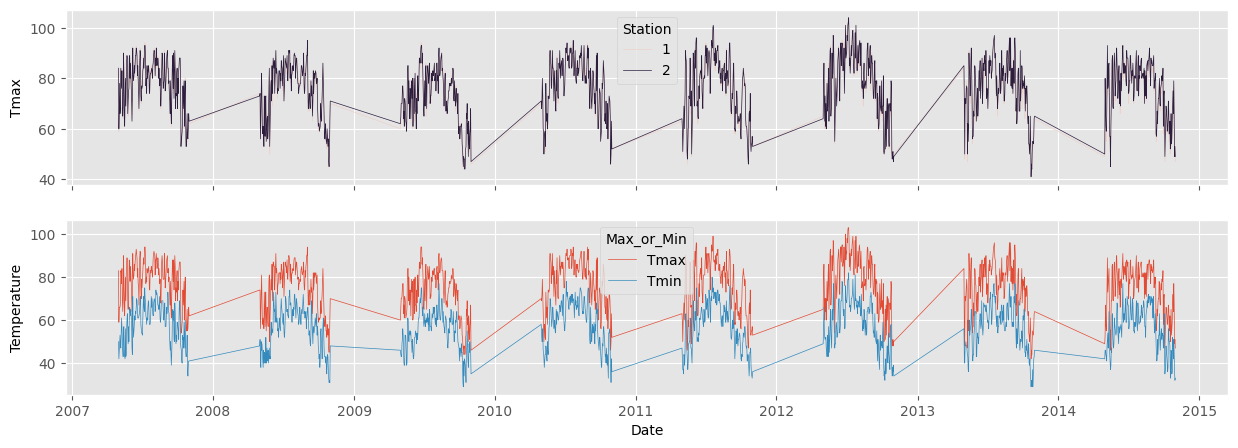

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,5))

## Tmax : station 1 vs station 2
sns.lineplot(x='Date', y='Tmax', hue='Station', data=weather, lw=0.5, ax=axes[0]);

## Tmax vs Tmin @ Station 1
sns.lineplot(x='Date', y='Temperature', hue='Max_or_Min', data=weather1[['Date','Tmax', 'Tmin']].melt('Date', var_name='Max_or_Min', value_name='Temperature'), lw=0.5, ax=axes[1]);

### what are `Heat` and `Cool`?

- they strongly correlate with temperature

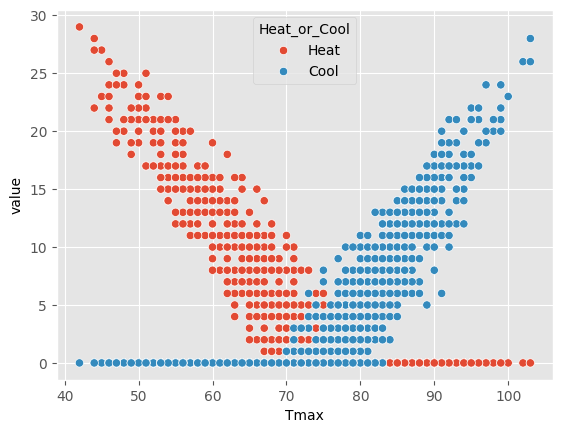

In [21]:
## cast datatype as int (original: string)
weather1['Heat'] = weather1.Heat.astype(int)
weather1['Cool'] = weather1.Cool.astype(int)

## scatter Tmax vs Heat/Cool
sns.scatterplot(x='Tmax', y='value', hue='Heat_or_Cool',  data=weather1[['Tmax', 'Heat', 'Cool']].melt('Tmax', var_name='Heat_or_Cool'));

In [22]:
## drop columns
weather1.drop(columns=['Heat','Cool'], inplace=True)

### `CodeSum`

- abbreviation of weather 
    - e.g. `RA`: rain, `BR`: mist, `HZ`: haze
- one day can have multiple values: `RA` & `SN`

In [23]:
## list of string
weather_list = weather1.CodeSum.apply(lambda x: x.strip().split(' ')) 

## make unique list 
weather_count = Counter()
weather_count.update(sum(weather_list, []))
print('num of weather :', len(weather_count.keys()))

## sort values
weather_count.most_common()

num of weather : 15


[('', 805),
 ('RA', 475),
 ('BR', 411),
 ('TSRA', 150),
 ('HZ', 105),
 ('DZ', 58),
 ('TS', 53),
 ('FG+', 16),
 ('FG', 11),
 ('VCTS', 8),
 ('FU', 5),
 ('BCFG', 3),
 ('MIFG', 3),
 ('SQ', 1),
 ('SN', 1)]

#### `is_rain` vs `Tmax`/`Tmin`

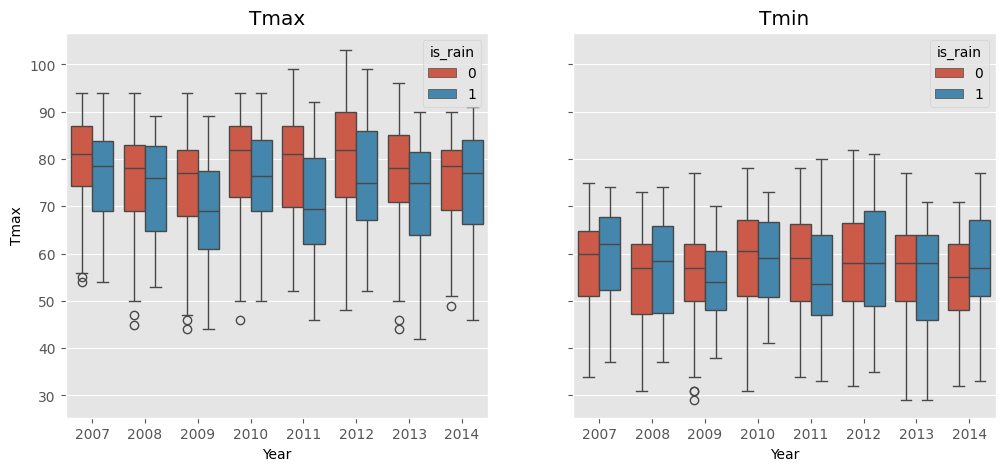

In [24]:
## boxplot 
weather1['is_rain'] = weather_list.apply(lambda x: 'RA' in x).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.boxplot(x='Year', hue='is_rain', y='Tmax', data=weather1, ax=axes[0]); axes[0].set_title('Tmax');
sns.boxplot(x='Year', hue='is_rain', y='Tmin', data=weather1, ax=axes[1]); axes[1].set_title('Tmin');

## 1.5. join tables

In [25]:
merged_df = train.merge(right=weather1, on=['Date','Year','Month'], how='left')

#### does `Tmax` correlate with `WnvPresent`?

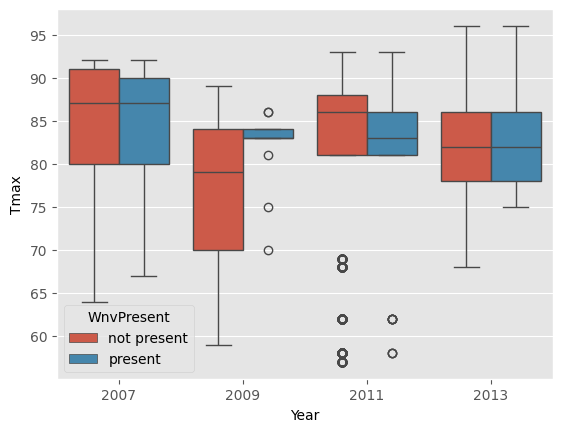

In [26]:
sns.boxplot(x='Year', hue='WnvPresent', y='Tmax', data=merged_df);

#### does `is_rain` correlate with `WnvPresent`?

In [27]:
merged_df.groupby(['Year', 'is_rain'])['WnvPresent'].value_counts(normalize=True).unstack(level=0) * 100

Year                      2007       2009       2011       2013
is_rain WnvPresent                                             
0       not present  95.629300  98.975860  97.096594  89.636689
        present       4.370700   1.024140   2.903406  10.363311
1       not present  90.447761  99.433107  98.098859  90.883590
        present       9.552239   0.566893   1.901141   9.116410

#### does `is_rain` correlate with `NumMosquitos`?

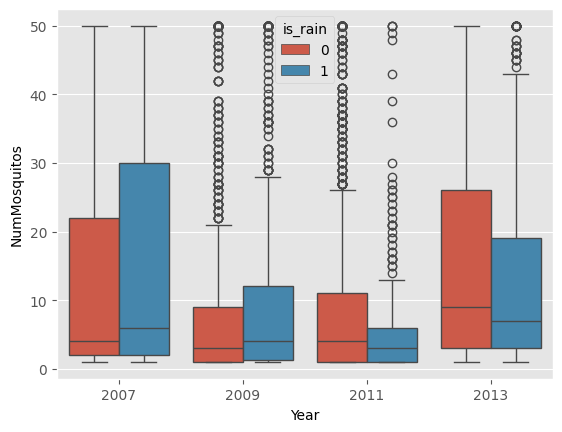

In [28]:
sns.boxplot(x='Year', hue='is_rain', y='NumMosquitos', data=merged_df);

#### create "past" features

In [29]:
def get_past_temp(date, past_days=3, temp='Tmax'):
    weather_filter = (weather1.Date < date) & (weather1.Date >= date - timedelta(days=past_days))
    return weather1[weather_filter][temp].mean()

def get_past_rain(date, past_days=3):
    weather_filter = (weather1.Date < date) & (weather1.Date >= date - timedelta(days=past_days))
    return weather1[weather_filter]['is_rain'].sum()

merged_df['Tmax_past3'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmax'))
merged_df['Tmax_past7'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmax'))
merged_df['Tmin_past3'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmin'))
merged_df['Tmin_past7'] = merged_df['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmin'))
merged_df['Rain_past3'] = merged_df['Date'].apply(lambda x: get_past_rain(x, 3))

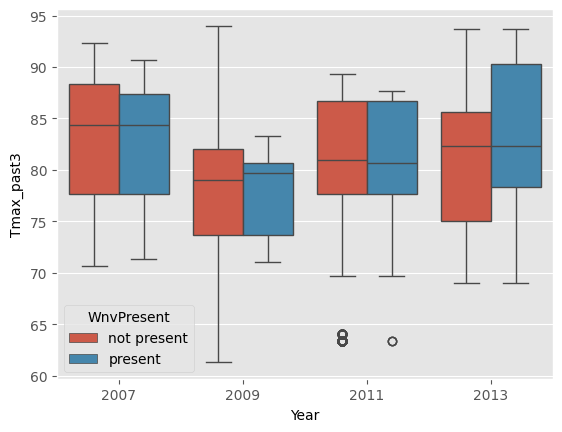

In [30]:
sns.boxplot(y='Tmax_past3', x='Year', hue='WnvPresent', data=merged_df);

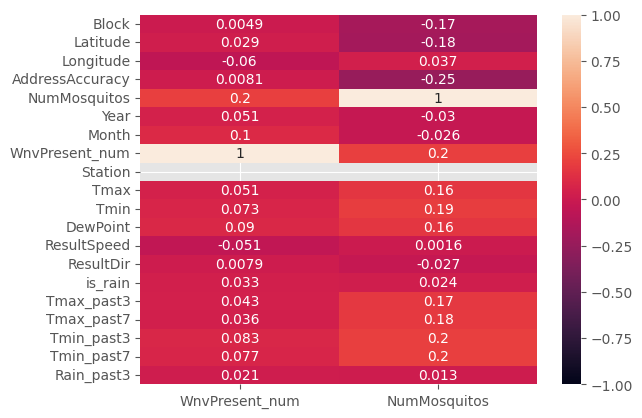

In [31]:
## Correlations
sns.heatmap(merged_df.corr(numeric_only=True)[['WnvPresent_num','NumMosquitos']], annot=True, vmin=-1, vmax=1);

## 1.6. recent WNV present

- use approximate distance
    - mean (41.94, -87.72)
    - 111.11km / 1 degree for latitude
    - 111.11*cos(41.94) = 82.64km / 1 degree for longitude

- create new features:
    - `recent_distance`
    - `recent_daybefore`
    - `recent_NumMosquitos`

In [32]:
present_df = train[train.WnvPresent_num==1].reset_index(drop=True).copy()
present_df.rename(columns={'NumMosquitos':'recent_NumMosquitos'}, inplace=True)

def get_distance(row, latitude, longitude):
    lat_diff = abs(row['Latitude'] - latitude)
    long_diff = abs(row['Longitude'] - longitude)
    return ((lat_diff * 111.11)**2 + (long_diff * 82.64)**2)**0.5

def get_recent_present(row, past_days=20, lat_width=0.1, long_width=0.1):
    date, latitude, longitude = row['Date'], row['Latitude'], row['Longitude']
    date_condition = (present_df.Date < date) & (present_df.Date >= date - timedelta(days=past_days))
    lat_condition = (present_df.Latitude - latitude).abs() < lat_width 
    long_condition = (present_df.Longitude - longitude).abs() < long_width
    filtered_df = present_df[date_condition & lat_condition & long_condition].copy()
    
    ## calculate distance to each point
    filtered_df['recent_distance'] = filtered_df.apply(lambda row: get_distance(row, latitude, longitude), axis=1)
    filtered_df['recent_daybefore'] = filtered_df['Date'].apply(lambda x: (date-x).days)
    if len(filtered_df) > 0:
        filtered_df = filtered_df.sort_values('recent_NumMosquitos', ascending=False)
        return filtered_df[['recent_distance', 'recent_daybefore','recent_NumMosquitos']].sort_values(['recent_daybefore','recent_distance']).iloc[0]
    else:
        return pd.Series({'recent_distance': 30, 'recent_daybefore':100, 'recent_NumMosquitos': 0})

## example
s = train.loc[10001]
get_recent_present(s)


recent_distance        2.508442
recent_daybefore       7.000000
recent_NumMosquitos    4.000000
Name: 420, dtype: float64

In [33]:
merged_df = pd.concat([merged_df, merged_df.apply(get_recent_present, axis=1)], axis=1)
merged_df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   ...  AvgSpeed is_rain  Tmax_past3  Tmax_past7 Tmin_past3  Tmin_past7  \
0  ...       6.5       0        73.0        79.0       52.0   55.714286   
1  ...       6.5       0        73.0        79.0       52.0   55.714286   
2  ...       6.5       0        73.0        79.0       52.0   55.714286   
3  ...       6.5       0        73.0        79.0       52.0   55.714286   
4  ...       6.5       0        73.0        79.0       52.0   55.714286   

   Rain_past3  recent_distance  recent_daybefore recent_NumMosquitos  
0           3             30.0             100.0                 0.0  
1           3             30.0             100.0                 0.0  
2           3             30.0             100.0                 0.0  
3           3             30.0             100.0                 0.0  
4           3             30.0             100.0                 0.0  

[5 rows x 44 columns]

<Axes: xlabel='recent_distance', ylabel='Count'>

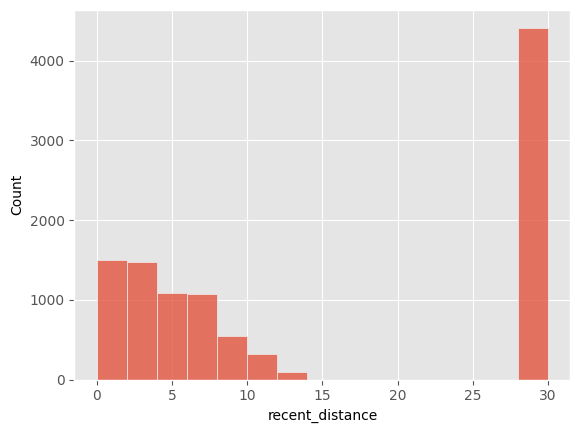

In [34]:
sns.histplot(merged_df['recent_distance'])

# 2. Modelling

In [35]:
feature_num = ['Year', 'Month', 'Tmax_past3', 'Tmin', 'Tmin_past3', 'is_rain', 'Rain_past3', 'recent_distance', 'recent_daybefore','recent_NumMosquitos']
feature_cat = ['Species', 'Street']

## dummify categorical features
X = pd.get_dummies(merged_df[feature_num+feature_cat], columns=feature_cat, drop_first=True, dtype=int)
y = merged_df['WnvPresent_num']

## scaling
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

## train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8404, 143) (8404,)
(2102, 143) (2102,)


In [36]:
def evaluate(model):
    pred_test = model.predict(X_test)
    probs_train = model.predict_proba(X_train)[:,1]
    probs_test = model.predict_proba(X_test)[:,1]
    auc_train = roc_auc_score(y_train, probs_train).round(4)
    auc_test = roc_auc_score(y_test, probs_test).round(4)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)

    ## plot
    plt.figure(figsize=(12, 5))
    
    ## confusion matrix
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test)).plot(ax=ax)
    plt.grid(False); plt.title('Confusion Matrix for test')

    ## ROC curve
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=auc_train).plot(ax=ax, name='train')
    RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=auc_test).plot(ax=ax, name='test')
    plt.plot((0,1), (0,1)); plt.title(f'ROC curve (AUC: {auc_test})')
    plt.show()


### 2.1. Logistic Regression

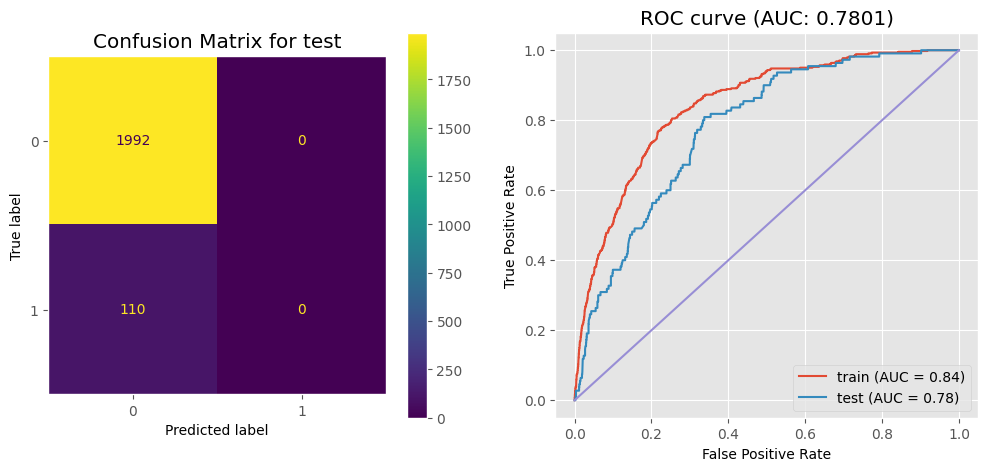

In [37]:
lr = LogisticRegression(max_iter=1000, C=0.01)
lr.fit(X_train, y_train)
evaluate(lr)

### 2.2. Random Forest

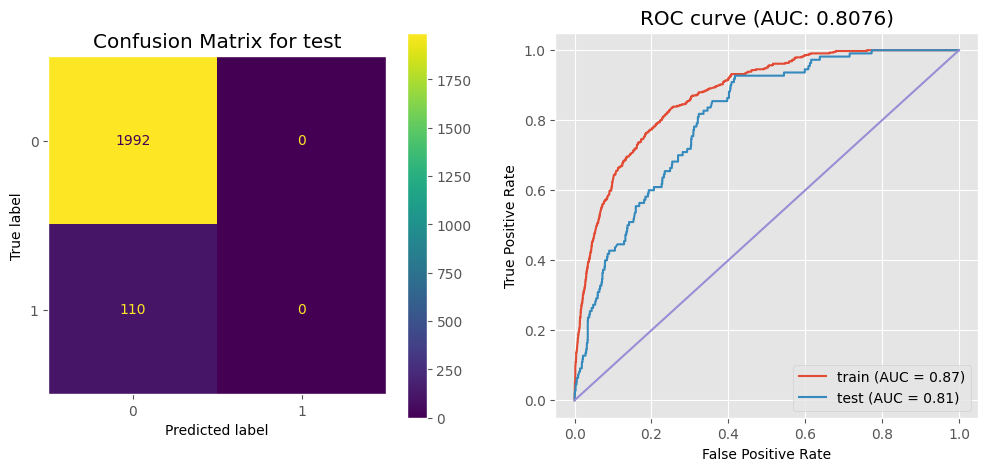

In [38]:
rf = RandomForestClassifier(max_depth=5, n_estimators=200)
rf.fit(X_train, y_train)
evaluate(rf)

### 2.3. XGBoost 

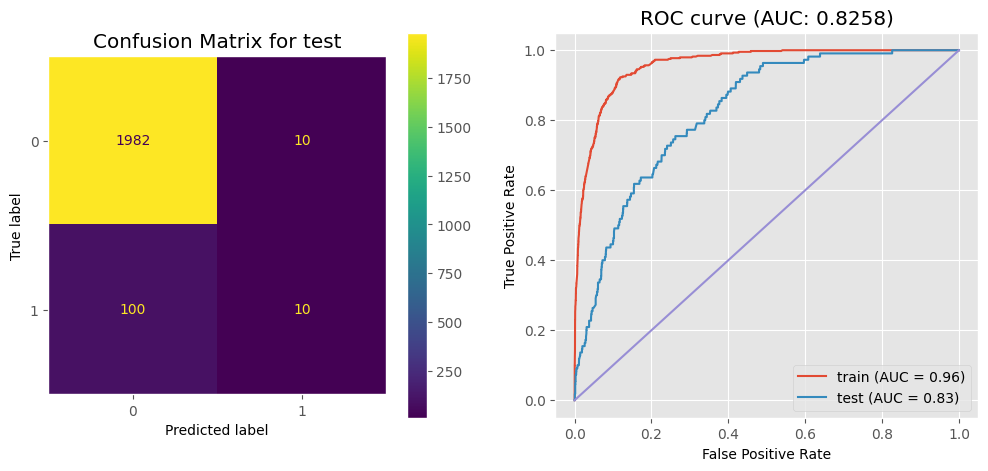

In [39]:
xg = XGBClassifier(max_depth=4, n_estimators=200)
xg.fit(X_train, y_train)
evaluate(xg)

### 2.4. AdaBoost

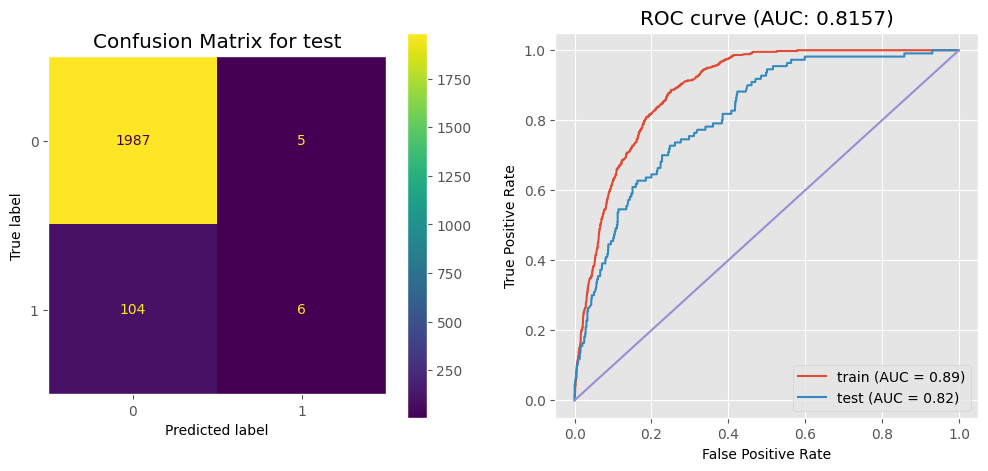

In [40]:
ada = AdaBoostClassifier(n_estimators=200)
ada.fit(X_train, y_train)
evaluate(ada)

### 2.5. SVC

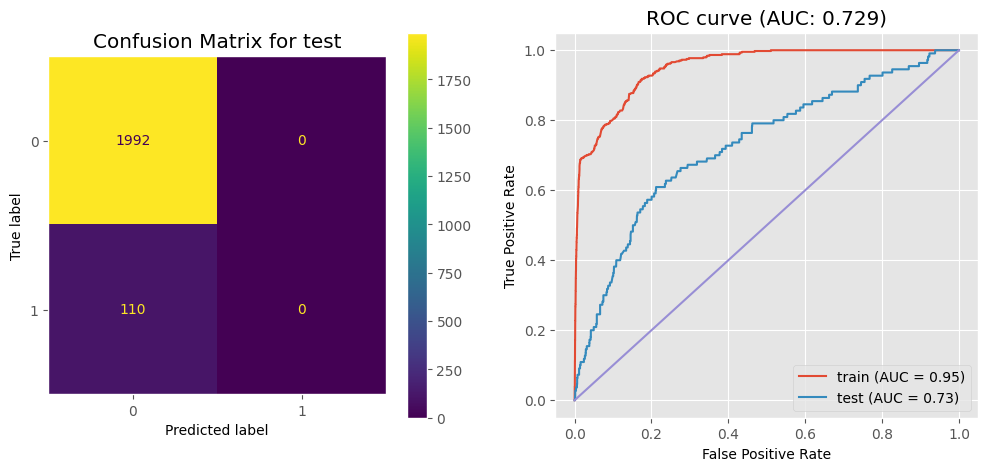

In [41]:
svc = SVC(probability=True, degree=2)
svc.fit(X_train, y_train)
evaluate(svc)

### 2.6 simpleNN

Epoch 1/3


2023-11-17 10:32:50.594226: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-17 10:32:50.594247: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-17 10:32:50.594251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-17 10:32:50.594278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 10:32:50.594292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-17 10:32:51.199935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-17 10:32:51.227110: E t

211/211 [==============================] - 3s 10ms/step - loss: 0.2666 - accuracy: 0.9396 - val_loss: 0.2066 - val_accuracy: 0.9488
Epoch 2/3
211/211 [==============================] - 2s 9ms/step - loss: 0.2245 - accuracy: 0.9459 - val_loss: 0.2067 - val_accuracy: 0.9488
Epoch 3/3
66/66 [==============================] - 0s 2ms/step


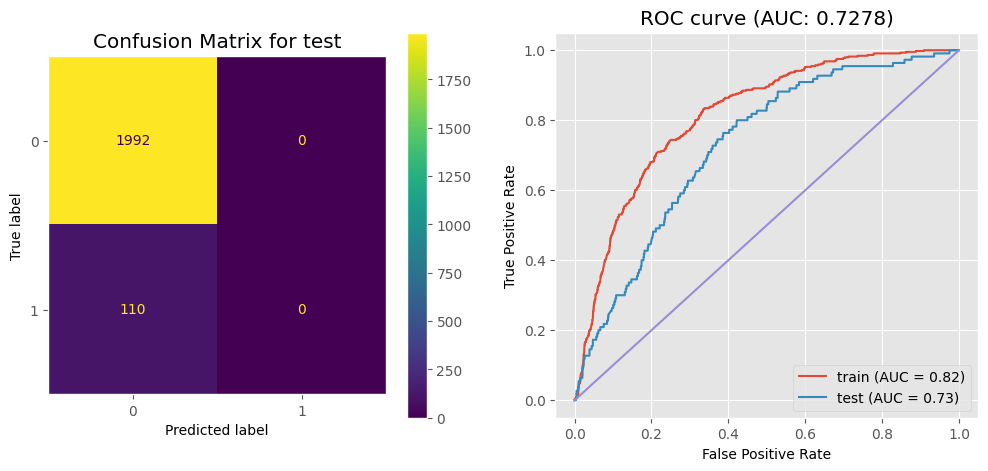

In [42]:
def create_NN(meta={}):
    ## used in scikeras wrapper
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    ## Instantiate Model with 2 hidden layers
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:])) # input layer
    model.add(Dense(128, activation='relu', name=f'Hidden1')) # 1st hidden layer
    model.add(Dropout(0.5, name=f'Dropout1')) 
    model.add(Dense(128, activation='relu', name=f'Hidden2')) # 2nd hidden layer
    model.add(Dropout(0.5, name=f'Dropout2')) 
    model.add(Dense(32, activation='relu', name=f'Hidden3')) # 2nd hidden layer
    model.add(Dropout(0.5, name=f'Dropout3')) 
    model.add(Dense(n_classes_, activation='softmax', name='Output')) # output layer
    return model

NN = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=3, metrics='accuracy', validation_split=0.2)
NN.fit(X_train, y_train)
evaluate(NN)

# submission


In [43]:
## Create new columns : year, month, year_month
test['Date'] = pd.to_datetime(test.Date)
test['Year'] = test.Date.dt.year
test['Month'] = test.Date.dt.month
test['Year_Month'] = test.apply(lambda row: str(row['Year'])+'_'+str(row['Month']).zfill(2), axis=1)

## join tables
merged_test = test.merge(right=weather1, on=['Date','Year','Month'], how='left')

## create weather features
merged_test['Tmax_past3'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmax'))
merged_test['Tmax_past7'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmax'))
merged_test['Tmin_past3'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 3, 'Tmin'))
merged_test['Tmin_past7'] = merged_test['Date'].apply(lambda x: get_past_temp(x, 7, 'Tmin'))
merged_test['Rain_past3'] = merged_test['Date'].apply(lambda x: get_past_rain(x, 3))

## create recent feature
merged_test = pd.concat([merged_test, merged_test.apply(get_recent_present, axis=1)], axis=1)

In [44]:
## dummify categorical features
## scaling
X_test = pd.get_dummies(merged_test[feature_num+feature_cat], columns=feature_cat, drop_first=True, dtype=int)
X_test, _ = X_test.align(X_train, join='right', axis=1, fill_value=0)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

## re-fit
xg.fit(X, y)

## predict
prediction = ada.predict_proba(X_test)[:,1]
result_df = merged_test.copy()
result_df['WnvPresent'] = prediction

result_df[['Id','WnvPresent']].to_csv('submission.csv', index=False)